<a href="https://colab.research.google.com/github/mosfet-sudo/ML-Project-G75/blob/main/90049_A2_G75_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP90049 (IML) → A2 GROUP 75 PROJECT CODE**


---


Elijah Cullinan, 1352251, ecullinan@student.unimelb.edu.au

Amelia King, 1175861, kingal@student.unimelb.edu.au

Xinyu Xu, 1508869, xinyu11@student.unimelb.edu.au


---



*   Linked to (public) GitHub *mosfet-sudo/ML-Project-G75*
    * *Note → GitHub must be public in order for us to view the 'live updates' of any changes made, as well as to more easily do common File I/O operations*
*   List item


---



## Reading appropriate files into this Notebook
In order for this shared notebook to work, files must be shared & filepaths must be generic to that file sharing method. There are two options for this; option 1 should be the main method, use option2 if option 1 doesn't work for whatever reason.

Code blocks will need to be adjusted according to whatever method being used (wherever the files are being read from as well as where output files are saved), and both the repository&drive must be updated so that they reflect all the changes.

### Option 1: Read directly from *mosfet-sudo/ML-Project-G75*
Run the appropriate code block below for the Colab notebook to read files directly from the

### Option 2: Mount Google Drive

Run the appropriate code block below to mount your google drive to this colab notebook for however long you need to be running the code for.

*NOTE: You must accept Amelia's invitation to share the drive folder 'IML_G75_Colab_Notebooks in order for this to work as intended.*


In [ ]:
# OPTION 1: READ FROM GITHUB
!git clone https://github.com/mosfet-sudo/ML-Project-G75



fatal: destination path 'ML-Project-G75' already exists and is not an empty directory.


In [ ]:
# OPTION 2: MOUNT GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

# directory for data (to share via google drive):
# '/content/drive/My Drive/IML_G75_Colab_Notebooks/...'

# DELTE FOR FINAL SUBMISSION!! #


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/IML_G75_Colab_Notebooks/


 CMaps_NASA
'COMP90049 G75 RESEARCH PROJECT NOTES.gdoc'
'IML_G75_Copy_(EMPTY).ipynb'
 METROPT3_AVGMINUTEPROCESSED.csv
 METROPT3_AVGMINUTEPROCESSED_WITHTIMES.csv
 NASAprocessed.csv
 pdm_2020.csv


## **Simple Data Processing**
*Elijah*

Each Dataset was checked for duplicate entries, and then specific numeric values were normalized. In addition to this there was some minor text processing of the NASA dataset where the text files were tranferred into csv format. Furthermore adjustments were made to the metrodataset where all data points of each minute were averaged in order to make the dataset smaller. In particular for values that were binary (i.e) 1 or 0 if the average was strictly greater than 0.5 then it was set to 1 otherwise it was set to 0. This averaging should reduce noise and reduce the affect of anomalous outliers.

### Metro-PT3
The raw data file is very large; seeing as Elijah has already completed the simple pre-processing it would be advisable not to run this code block again.

In [ ]:
import pandas as pd
import numpy as np
import json

""" Averaging function for new dataset that preserves when errors occur, n must
be even n=6 for averaging every minute. Takes the data frame, the number of
samples to bunch together and average and the indexes that are we are applying
the average of. The inputs are the data frame, an integer n, and 2 arrays of
numeric indexes. Returns the new (smaller) averaged dataframe. """
# above copied from below documentation; will need to be cleaned up bc half those sentences don't make no sense

## averaging function for new dataset that preserves when errors occur, n must be even n=6 for averaging every minute
## takes the data  frame the number of samples to bunch together and average and the indexes that are we are applying the averaging off.
## the inputs are the data frame, an integer n, and 2 arrays of numeric indexes it returns the new (smaller) averaged dataframe

def timeAvg(df, n, tempindexes, elec_temp_indexes):
    m = n/2
    m = int(m)

    df_empty = df.copy(deep=True).iloc[0:0]
    avg_atpoints = []
    max_atpoints = []
    for i in tempindexes:
        print(i)
        avg_atpoints = []
        temp_series = df.iloc[:,i]
        numrows = int(temp_series.shape[0])
        for j in range(m, int(numrows-m),n):
            avg_atpoints.append(temp_series.iloc[j-m:j+m].mean()) #here we take the average
        df_empty.iloc[:,i] = avg_atpoints
    for i in elec_temp_indexes:
        print(i)
        max_atpoints = []
        temp_series = df.iloc[:,i]
        numrows = int(temp_series.shape[0])
        for j in range(m, int(numrows-m),n):
            avg = temp_series.iloc[j-m:j+m].mean()  #we use the average to decide what to assign to this datapoint
            if avg > 0.5:
                max_atpoints.append(1)
            else:
                max_atpoints.append(0)
        df_empty.iloc[:,i] = max_atpoints
    df_empty.iloc[:,0] = list(range(1,df_empty.shape[0]+1))
    return df_empty


# df = pd.read_csv("C:/Users/ej/PycharmProjects/Assignment2/.venv/Scripts/MetroPT3(AirCompressor).csv") -> DELETE (Elijah)
# df = pd.read_csv('') # OPTION1: GITHUB
df = pd.read_csv('/content/drive/My Drive/IML_G75_Colab_Notebooks/') # OPTION2: GOOGLE DRIVE



#Duplicate checking
df = df.drop(columns = ["timestamp"])
num_columns = df.shape[1]
num_rows = df.shape[0]
duplicateddf=df.duplicated()
no_duplicate_df = df.loc[duplicateddf==False]


no_duplicate_df.rename(columns={"Unnamed: 0": "Time Elapased [seconds]"}, inplace=True)
print(no_duplicate_df.columns)

# Normalisation
# Find the indexes of columns which have values we want to normalize
temp_indexes = [no_duplicate_df.columns.get_loc("Time Elapased [seconds]")] ##SHOULD WE NORMALIsE THIS?
temp_indexes.append(no_duplicate_df.columns.get_loc("TP2"))
temp_indexes.append(no_duplicate_df.columns.get_loc("TP3"))
temp_indexes.append(no_duplicate_df.columns.get_loc("H1"))
temp_indexes.append(no_duplicate_df.columns.get_loc("DV_pressure"))
temp_indexes.append(no_duplicate_df.columns.get_loc("Reservoirs"))
temp_indexes.append(no_duplicate_df.columns.get_loc("Oil_temperature"))
temp_indexes.append(no_duplicate_df.columns.get_loc("Motor_current"))


# BOTH RPM AND TOOLWEAR HAVE ISSUES WITH CERTAIN DTYPES BEING INT DUE TO WHOLE NUMBERS IN DATA
no_duplicate_df["Time Elapased [seconds]"] = no_duplicate_df["Time Elapased [seconds]"].astype(float)

#for each index normalize the values and for each row set the value to the normalized value
for i in temp_indexes:
    temp_series = no_duplicate_df.iloc[:,i]
    series_max = temp_series.max()
    series_min = temp_series.min()
    series_range = temp_series.max() - temp_series.min()

    for j in range(temp_series.shape[0]):

        no_duplicate_df.iat[j,i] = (no_duplicate_df.iat[j,i]-series_min)/series_range



## new temp indexes for finding columns of electrical signal data
elec_temp_indexes = [no_duplicate_df.columns.get_loc("COMP")]
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("DV_eletric"))
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("Towers"))
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("MPG"))
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("LPS"))
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("Pressure_switch"))
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("Oil_level"))
elec_temp_indexes.append(no_duplicate_df.columns.get_loc("Caudal_impulses"))



no_dupe_normalized_df = no_duplicate_df
no_dupe_normalized_df_avg = timeAvg(no_dupe_normalized_df,6,temp_indexes,elec_temp_indexes)

no_dupe_normalized_df_avg.to_csv("METROPT3_AVGMINUTEPROCESSED.csv")

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/IML_G75_Colab_Notebooks/'

### NASA

In [ ]:
import pandas as pd
import numpy as np
import os

#Method for parsing text files into dataframe, takes a string input and returns a dataframe object
def parseTxt2Dataframe(String):
    with open(String, 'r', encoding='utf-8') as file:
        lines = []
        for line in file:
            newline = line.strip()
            newline = newline.split()
            lines.append(newline)
        new_df = pd.DataFrame(lines, columns=['Unit Number', 'Time in cycles',
                                  'Operational Setting 1', 'Operational Setting 2','Operational Setting 3',
                                  'T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc',
                                  'BPR','farB','htBleed','Nf_dmd','PCNfr_dmd','W31','W32'])
        num_cols = new_df.shape[1]
        for i in range(num_cols):
            new_df.iloc[:,i] = pd.to_numeric(new_df.iloc[:,i])


    return new_df

#normalizes the data, and checks for duplicates, takes dataframe object as input and returns a dataframe
def normalize_and_checkdupe(df):
    checkdf = df.drop(columns=['Unit Number','Time in cycles'])
    duplicateddf = checkdf.duplicated()
    no_dupe_df = df.loc[duplicateddf==False]
    num_cols = no_dupe_df.shape[1]
    num_rows = no_dupe_df.shape[0]
    for i in range(2,num_cols):
        max_val = no_dupe_df.iloc[:,i].max()
        min_val = no_dupe_df.iloc[:,i].min()
        val_range = max_val - min_val
        for j in range(num_rows):
            if val_range != 0:
                no_dupe_df.iat[j, i] = (no_dupe_df.iat[j, i] - min_val) / val_range
            else:
                no_dupe_df.iat[j, i] = -1

    return no_dupe_df

# parsing each text file into a dataframe -> OPTION 1: GITHUB

# parsing each text file into a dataframe -> OPTION 2: GOOGLE DRIVE
df_test1 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/test_FD001.txt')
df_test2 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/test_FD002.txt')
df_test3 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/test_FD003.txt')
df_test4 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/test_FD004.txt')
df_train1 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/train_FD001.txt')
df_train2 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/train_FD002.txt')
df_train3 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/train_FD003.txt')
df_train4 = parseTxt2Dataframe('/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA/train_FD004.txt')








#combining the data into one dataset

df_all = pd.concat([df_test1,df_test2,df_test3,df_test4,df_train1,df_train2,df_train3,df_train4],ignore_index=True)
print(df_all.shape)
print(df_test1.shape)

## normalizing and checking for duplicates when combined
df_all_processed = normalize_and_checkdupe(df_all)

## normalizing and checking for duplicates when uncombined
df_test1_processed = normalize_and_checkdupe(df_test1)
#df_test2_processed = normalize_and_checkdupe(df_test2)
#df_test3_processed = normalize_and_checkdupe(df_test3)
#df_test4_processed = normalize_and_checkdupe(df_test4)
#df_train1_processed = normalize_and_checkdupe(df_train1)
#df_train2_processed = normalize_and_checkdupe(df_train2)
#df_train3_processed = normalize_and_checkdupe(df_train3)
#df_train4_processed = normalize_and_checkdupe(df_train4)



## testing and debug
pd.set_option('display.max_columns', None)
print(df_all_processed.shape)
print(df_all_processed.head())
print(df_test1_processed.head())
print("newline")


print("newline")
print(df_all_processed.shape)

pd.reset_option('display.max_columns')
df_all_processed.to_csv('NASAprocessed.csv')

(265256, 26)
(13096, 26)
(265256, 26)
  Unit Number Time in cycles Operational Setting 1 Operational Setting 2  \
0           1              1              0.000262              0.001068   
1           1              2              0.000143              0.000356   
2           1              3              0.000214              0.000831   
3           1              4              0.000307              0.000712   
4           1              5               0.00024              0.000712   

  Operational Setting 3   T2       T24       T30       T50   P2  P15  \
0                   1.0  1.0  0.980948  0.915898   0.89639  1.0  1.0   
1                   1.0  1.0  0.969006  0.924302  0.889711  1.0  1.0   
2                   1.0  1.0  0.975843  0.920286  0.903883  1.0  1.0   
3                   1.0  1.0  0.975661  0.912786  0.916044  1.0  1.0   
4                   1.0  1.0  0.976299  0.920951  0.905271  1.0  1.0   

        P30        Nf        Nc       epr    Ps30       phi       NRf  \

### PdM

In [ ]:
import pandas as pd
import numpy as np
import json

# df = pd.read_csv("C:/Users/ej/PycharmProjects/Assignment2/.venv/Scripts/ai_2020.csv") DELETE -> Elijah
# df = pd.read_csv('') # OPTION1: GITHUB
df = pd.read_csv('/content/drive/My Drive/IML_G75_Colab_Notebooks/ai_2020.csv') # OPTION2: GOOGLE DRIVE

#Duplicate checking

df = df.drop(columns = ["UDI"])
num_columns = df.shape[1]
num_rows = df.shape[0]
duplicateddf=df.duplicated()
no_duplicate_df = df.loc[duplicateddf==False]

print(no_duplicate_df.columns)
#Normalization

temp_indexes = [no_duplicate_df.columns.get_loc("Air temperature [K]")]
temp_indexes.append(no_duplicate_df.columns.get_loc("Process temperature [K]"))
temp_indexes.append(no_duplicate_df.columns.get_loc("Rotational speed [rpm]")) #TURN INTO SECONDS?
temp_indexes.append(no_duplicate_df.columns.get_loc("Torque [Nm]"))
temp_indexes.append(no_duplicate_df.columns.get_loc("Tool wear [min]"))     # TURN INTO SECONDS?
# BOTH RPM AND TOOLWEAR HAVE ISSUES WITH CERTAIN DTYPES BEING INT DUE TO WHOLE NUMBERS IN DATA
no_duplicate_df["Rotational speed [rpm]"] = no_duplicate_df["Rotational speed [rpm]"].astype(float)
no_duplicate_df["Tool wear [min]"] = no_duplicate_df["Tool wear [min]"].astype(float)

for i in temp_indexes:

    temp_series = no_duplicate_df.iloc[:,i]
    series_max = temp_series.max()
    series_min = temp_series.min()
    series_range = temp_series.max() - temp_series.min()

    for j in range(temp_series.shape[0]):

        no_duplicate_df.iat[j,i] = (no_duplicate_df.iat[j,i]-series_min)/series_range


no_dupe_normalized_df = no_duplicate_df

no_dupe_normalized_df.to_csv("PredicitiveMaintenanceDatasetPROCESSED.csv")

## **Advanced Pre-Processing**
*Xinyu, Elijah & Amelia*

See sections below to get more details on how we all completed the advanced pre-processing of our datasets.

*Note → around this point, we decided that we would likely not be using the PdM dataset any further.*

### Metro PT-3
*Xinyu & Elijah*

[insert notes on what processing methods were used and why, here]

* Majority class ensemble: want models that are better than random guessing

* Greater standard deviations should have more weights
* Whenever peak detected, ...
* For more extreme/large events, cumulatively add score
  * Issue: maintenance done on machine








In [ ]:
# [insert correct code here] #

#### Amelia's notes on Metro PT-3 advanced pre-processing
*Mixed up which dataset I was meant to process, please enjoy my notes*

Advanced pre-processing focused on the following sub-question:
*   How well do electrical load (Motor_current), temperature (Oil_temperature), and output pressure (TP2, TP3) predict compressor stress or early failure?



---

**Elijah Notes on Amelia's code**

Looking at *causes;* want things to be generealisable

`df["Temp_x_current"] = df["Oil_temperature"] * df["Motor_current"]              # thermal stress`

* Want features to be linearly related
  * allows to more directly pinpoint what is causing failure (e.g., failure caused by overheating)
* Absolute values VS ratio (dimensional analysis)

`df["Motor_delta"] = df["Motor_current"].diff().fillna(0)                        # system stability over time (pt2)`

* Actual current matters; high current burns wires, for example
* Want to look at ratio of the current *now* over the most common (recent) operation range → how far away are these values from one another in terms of a ratio? (maybe make combined score with absolute value to weight both)
   * More focus on generealisability

In [ ]:
### Amelia's mistake code ###
# ---------------------------------------------------------------------------- #
from sklearn.preprocessing import MinMaxScaler
import numpy as np
"""
# import dataset and stuff

# make sure that simple pre-processed dataset is clean & normalised
df = df.dropna()
df = df.sort_values("Time Elapased [seconds]")

# scale numeric features for ordinal SVM
features = ["Motor_current", "Oil_temperature", "TP2", "TP3", "Reservoirs"]
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])



# creating derived features
df["Temp_x_current"] = df["Oil_temperature"] * df["Motor_current"]              # thermal stress => MARK FOR CHANGE
df["Pressure_ratio"] = df["TP2"] / (df["TP3"] + 1e-6)                           # compressor efficiency
df["Reservoir_diff"] = df["Reservoirs"].diff().fillna(0)                        # system stability over time => MARK FOR CHANGE: NORMALISE?
df["Motor_delta"] = df["Motor_current"].diff().fillna(0)                        # system stability over time (pt2: electric boogaloo) => MARK FOR DELETION

# ordinal target variable
df["State_of_health"] = np.select([(df["Oil_temperature"] < 0.4) & (df["Motor_current"] < 0.4), (df["Oil_temperature"] < 0.7) & (df["Motor_current"] < 0.7),],[0, 1],default=2)
"""
### Elijah's code ###
def addFailure(df, index):
    failurecolindex = df.columns.get_loc('Failure')
    for i in range(index[0], index[1]):
        df.iat[i, failurecolindex] = 1

df = pd.read_csv("C:/Users/ej/PycharmProjects/Assignment2/.venv/Scripts/METROPT3_AVGMINUTEPROCESSED.csv")

failureindex1 = [93761,95204]
failureindex2 = [140123,140517]
failureindex3 = [148468,151354]
failureindex4 = [195182,195453]
df["Failure"] = 0


addFailure(df,failureindex1)
addFailure(df,failureindex2)
addFailure(df,failureindex3)
addFailure(df,failureindex4)
### CONSTRUCTING DAYS TO FAILURE TARGET FEATURE
df["DaysToFailure"] = 0
D2Failurecolindex = df.columns.get_loc('DaysToFailure')
referenceday1 = df["DaysSinceStart"].iloc[failureindex1[0]]
referenceday2 = df["DaysSinceStart"].iloc[failureindex2[0]]
referenceday3 = df["DaysSinceStart"].iloc[failureindex3[0]]
referenceday4 = df["DaysSinceStart"].iloc[failureindex4[0]]
referencedaylast = df["DaysSinceStart"].iloc[-1]
for i in range(0,failureindex1[0]):
    df.iat[i, D2Failurecolindex] = referenceday1-df["DaysSinceStart"].iloc[i]

for i in range(failureindex1[1],failureindex2[0]):
    df.iat[i, D2Failurecolindex] = referenceday2-df["DaysSinceStart"].iloc[i]

for i in range(failureindex2[1],failureindex3[0]):
    df.iat[i, D2Failurecolindex] = referenceday3-df["DaysSinceStart"].iloc[i]

for i in range(failureindex3[1],failureindex4[0]):
    df.iat[i, D2Failurecolindex] = referenceday4-df["DaysSinceStart"].iloc[i]

for i in range(failureindex4[1],len(df)):
    df.iat[i, D2Failurecolindex] = referencedaylast - df["DaysSinceStart"].iloc[i]
#TRANFORM TO WEEKS IF NECESSARY
#CREATING DIMENSIONLESS FEATURES

power_temp_ratio = (df["Motor_current"]*df["Motor_current"])/(1e-6 + df["Oil_temperature"]) #WOULD delta temp be better?
reservior_flowrate = df["Reservoirs"].diff().fillna(0)
compressor_eff = df["TP2"] / (df["TP3"] + 1e-6)

#flicker values that tracks when any electrical signals are flipping
flicker_COMP = df["COMP"].diff().fillna(0)
flicker_DV = df["DV_eletric"].diff().fillna(0)
flicker_TOWER = df["Towers"].diff().fillna(0)
flicker_MPG = df["MPG"].diff().fillna(0)
flicker_LPS = df["LPS"].diff().fillna(0)
flicker_Pressure = df["Pressure_switch"].diff().fillna(0)
flicker_Oil = df["Oil_level"].diff().fillna(0)
flicker_CImpulse = df["Caudal_impulses"].diff().fillna(0)

# WANT to normalize each with respect to thier occurance and then add together
def weight(flicker):
    flicker = abs(flicker)

    newflicker = flicker * (1/(sum(flicker)+1e-6))
    return newflicker
flicker_COMP = weight(flicker_COMP)
flicker_DV =   weight(flicker_DV)
flicker_TOWER = weight(flicker_TOWER)
flicker_MPG = weight(flicker_MPG)
flicker_LPS = weight(flicker_LPS)
flicker_Pressure = weight(flicker_Pressure)
flicker_Oil =  weight(flicker_Oil)
flicker_CImpulse = weight(flicker_CImpulse)
combined_flicker = flicker_COMP + flicker_DV + flicker_TOWER + flicker_MPG + flicker_LPS + flicker_Pressure + flicker_Oil + flicker_CImpulse

data = {"power_temp_ratio":power_temp_ratio,"reserviour_flowrate":reservior_flowrate,"compressor_eff":compressor_eff, "flicker":combined_flicker}

#FINDING AVERAGES FOR DIFFERENT RELATIVE TIMES WITH REGARD TO DIMENSIONLESS FEATURES
# WILL GET A FAR AVERAGE (say 3 weeks ago ~ instances 20k-30k)
def addFarStats(df,colIndex):
    avgvals = []
    sdvals = []
    for i in range(30000,len(df)):
        values = df.iloc[:,colIndex]

        farvalues = values.iloc[i-30000:i-20000]

        avg = farvalues.mean()
        sd = farvalues.std()
        avgvals.append(avg)
        sdvals.append(sd)
    df[f"FarAvg{colIndex}"] = 0.0
    df[f"FarSD{colIndex}"] = 0.0
    newcol1 = df.columns.get_loc(f'FarAvg{colIndex}')
    newcol2 = df.columns.get_loc(f'FarSD{colIndex}')
    for i in range(30000,len(df)):
        df.iat[i, newcol1] = avgvals[i-30000]
        df.iat[i, newcol2] = sdvals[i-30000]
# OPTIONAL : GETS CLOSE STATISTICS
def addCloseStats(df,colIndex):
    avgvals = []
    sdvals = []
    for i in range(2000,len(df)):
        values = df.iloc[:,colIndex]

        farvalues = values.iloc[i-2000:i-1000]

        avg = farvalues.mean()
        sd = farvalues.std()
        avgvals.append(avg)
        sdvals.append(sd)
    df[f"CloseAvg{colIndex}"] = 0.0
    df[f"CloseSD{colIndex}"] = 0.0
    newcol1 = df.columns.get_loc(f'CloseAvg{colIndex}')
    newcol2 = df.columns.get_loc(f'CloseSD{colIndex}')
    for i in range(2000,len(df)):
        df.iat[i, newcol1] = avgvals[i-2000]
        df.iat[i, newcol2] = sdvals[i-2000]


# MAKE NEW DATAFRAME And calculate statistics
newdf = pd.DataFrame(data)
addFarStats(newdf,0)
addFarStats(newdf,1)
addFarStats(newdf,2)
addFarStats(newdf,3)

#import target features
newdf["Failure"] = df["Failure"]
newdf["Days2Failure"] = df["DaysToFailure"]

newdf.to_csv("TESTING.csv")


#import scaler
from sklearn.preprocessing import MinMaxScaler
### TAKE IN DATAFRAME
df = pd.read_csv("C:/Users/ej/PycharmProjects/Assignment2/.venv/Scripts/TESTING.csv")
### check for anomalous datapoints and construct series to determine which points are
### uses previously calculated means and std's to find abnormal instances (CAN BE adjusted by changing the multiplier in the if else statements)
def checkAnomalous(series1,seriesmeans,seriesstds):
    checkseries = []
    for i in range(len(series1)):
        if seriesmeans.iloc[i] == 0 and seriesstds.iloc[i] == 0:
            checkseries.append(0)
        elif series1.iloc[i] > seriesmeans.iloc[i]+2*seriesstds.iloc[i]:
            checkseries.append(1)
        elif series1.iloc[i] < seriesmeans.iloc[i]-2*seriesstds.iloc[i]:
            checkseries.append(1)
        else:
            checkseries.append(0)
    return checkseries

### takes cumulative values of last 10k instances of abnormal instances
def recentCumulative(checkseries):
    ## INITIAL CUMULATIVE
    recentCumulative = []
    recentCumulative = checkseries[0:10001].cumsum().tolist()
    print(len(recentCumulative))
    print("STARTING")
    for i in range(10001, len(checkseries)):
        newentry = (recentCumulative[i-1]+checkseries[i]-checkseries[i-10000])
        recentCumulative.append(newentry)
    return recentCumulative
# constructing new clean df and dropping unneeded features
newdf = df
newdf.drop(columns = ['Unnamed: 0'],inplace=True)

#for each feature we find the cumulative values from last 10k instnaces
for i in range(4):
    print(i)

    object = checkAnomalous(newdf.iloc[:,i],newdf[f"FarAvg{i}"],newdf[f"FarSD{i}"])
    newdf[f"checkseries{i}"] = checkAnomalous(newdf.iloc[:,i],newdf[f"FarAvg{i}"],newdf[f"FarSD{i}"])
    newdf[f"cummulativeseries{i}"] = recentCumulative(newdf[f"checkseries{i}"])

# renaming cumulative features
newdf.rename(columns={'cummulativeseries0':'cum_PTratio','cummulativeseries1':'cum_reserviourrate','cummulativeseries2':'cum_compressor_eff','cummulativeseries3':'cum_flicker'},inplace=True)

#dropping statistic features that are not needed
newdf.drop(columns = ['FarAvg0','FarAvg1','FarAvg2','FarAvg3','FarSD0','FarSD1','FarSD2','FarSD3','checkseries0','checkseries1','checkseries2','checkseries3'],inplace=True)
newdf.drop(range(30000), inplace=True)
# scaling each feature to be normalized
scaler = MinMaxScaler()
features = ["power_temp_ratio","reserviour_flowrate","compressor_eff","flicker",'cum_PTratio','cum_reserviourrate','cum_compressor_eff','cum_flicker']
newdf[features] = scaler.fit_transform(newdf[features])

###NEED TO CONVERT DAYS TO WEEKS AND CAP IT at 4 weeks
dayscolindex = newdf.columns.get_loc("Days2Failure")
for i in range(len(newdf)):
    if newdf.iloc[i,dayscolindex] > 28:
        newdf.iat[i,dayscolindex] = 4
    elif newdf.iloc[i,dayscolindex] >21:
        newdf.iat[i,dayscolindex] = 3
    elif newdf.iloc[i,dayscolindex] >14:
        newdf.iat[i,dayscolindex] = 2
    elif newdf.iloc[i,dayscolindex] >7:
        newdf.iat[i,dayscolindex] = 1
    elif newdf.iloc[i,dayscolindex] >0:
        newdf.iat[i,dayscolindex] = 0
    elif newdf.iloc[i,dayscolindex] == 0:
        newdf.iat[i,dayscolindex] = 0

newdf.rename(columns={"Days2Failure":"Weeks2Failure"},inplace=True)

newdf.to_csv("FINALMETRODATA.csv")

# NASA

*Xinyu & Amelia *

Advanced preprocessing involved...

* divide the dataset in DF ways instead of in training and test set
* data process: use average value to fill the NULL values; and use epsilon in case that the mean sqaure root be zero to be divided;
* save the data to data/processed root

（note）The IO files are based on local machine, regardless of onedrive

*Note: might need to fully translate all comments for final hand-in*

In [ ]:
import os
import pandas as pd
import numpy as np

# ========== sklearn used only during the scaling phase, but not directly here -> import StandardScaler ==========
# Using custom scaling logic: Fill + Normalise + ε smoothing

# Corrected column names from s1 to s21 (21 sensors in total)
COLS = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f's{i}' for i in range(1, 22)]
SENSOR_COLS = [f's{i}' for i in range(1, 22)]
ALL_FEATS = ['op1', 'op2', 'op3'] + SENSOR_COLS


def get_data_dir():
    """
    Locate the NASA CMAPSS data directory within Google Colab  # delete for final submission
    """
    data_dir = '/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA' # delete for final submission
    return data_dir # delete for final submission


    """
    自动定位 data/NASA 目录（相对于项目根目录）(D)
    Automatically locate the data/NASA directory (relative to the project root directory)
    [REPLACE THIS TEXT WITH END-DOCSTRING]
    this_dir = os.path.dirname(__file__)
    project_root = os.path.abspath(os.path.join(this_dir, os.pardir, os.pardir))
    data_dir = os.path.join(project_root, 'data', 'NASA')
    return data_dir
    """

def read_fd(fd: str):
    """
    读取 train 和 test 数据 (D)
    Read train_fd and test_fd files
    """
    data_dir = get_data_dir()
    train_path = os.path.join(data_dir, f"train_{fd}.txt")
    test_path  = os.path.join(data_dir, f"test_{fd}.txt")
    train = pd.read_csv(train_path, sep=r'\s+', header=None, names=COLS)
    test  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=COLS)
    # 有些列可能全是空值，dropna 会删除这些列。这里可以保守处理。(D)
    # Some columns may contain only null values; dropna will remove these columns. A conservative approach may be adopted here. --> is this Chat-GPT? (D)
    train = train.dropna(axis=1, how='all')
    test  = test.dropna(axis=1, how='all')
    return train, test

def read_rul(fd: str):
    """
    读取 RUL 文件 /
    Read official RUL file
    """
    data_dir = get_data_dir()
    rul_path = os.path.join(data_dir, f"RUL_{fd}.txt")
    rul = pd.read_csv(rul_path, header=None, names=['RUL'])
    return rul

def add_train_rul(df: pd.DataFrame) -> pd.DataFrame:
    """
    给训练集每行添加 RUL 列 / Add RUL to training set

    Add an RUL column to each row in the training set
    """
    max_cyc = df.groupby('unit')['cycle'].max().rename('max_cycle')
    df = df.merge(max_cyc, on='unit', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df = df.drop(columns=['max_cycle'])
    return df

def build_test_labels(test_df: pd.DataFrame, rul_vec: pd.DataFrame) -> pd.DataFrame:
    """
    用官方 RUL 和测试集最后时刻构造测试标签 / Build test labels per unit
    返回 DataFrame 包含 ['unit','RUL'] (D)

    Construct test labels per unit using official RUL and test set at the last moment
    Return a DataFrame containing [“unit”,'RUL']
    """
    last = test_df.groupby('unit')['cycle'].max().rename('last_cycle').reset_index()
    last = last.sort_values('unit').reset_index(drop=True)
    last['RUL'] = rul_vec['RUL'].values
    return last[['unit', 'RUL']]

def scale_by_train(train_df: pd.DataFrame, test_df: pd.DataFrame, eps: float = 1e-8):
    """
    填补缺失 + 标准化 + ε 平滑
    返回 train_scaled, test_scaled, scaler_params = (means, stds_adj) (D)

    Fill missing values, scale & standardise features, complete epsilon smoothing (to avoid dividing by zero)
    Return train_scaled, test_scaled, scaler_params = (means, stds_adj)
    """
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()

    # —— 1. 均值填补（用训练集均值填补 train & test 的缺失值）(D)
    # 1. Mean imputation (filling missing values in both training and test datasets with the mean from the training set)
    feat_means = train_df[ALL_FEATS].mean()
    train_scaled[ALL_FEATS] = train_scaled[ALL_FEATS].fillna(feat_means)
    test_scaled[ALL_FEATS]  = test_scaled[ALL_FEATS].fillna(feat_means)

    # —— 2. 计算标准差 & 平滑 (D)
    # 2. Calculating standard deviation & smoothing
    stds = train_scaled[ALL_FEATS].std(ddof=0)
    stds_adj = stds.copy()
    stds_adj[stds_adj < eps] = eps

    # —— 3. 标准化 (x - mean) / stds_adj (D)
    # 3. Normalise (x - mean) / stds_adj
    for feat in ALL_FEATS:
        train_scaled[feat] = (train_scaled[feat] - feat_means[feat]) / stds_adj[feat]
        test_scaled[feat]  = (test_scaled[feat]  - feat_means[feat]) / stds_adj[feat]

    scaler_params = (feat_means, stds_adj)
    return train_scaled, test_scaled, scaler_params

def process_fd(fd: str):
    """
    为一个 FD 子集做完整处理（读取、加 RUL、缩放、保存 (D)
    Process one FD subset end-to-end; perform complete processing on an FD subset (read, add RUL, scale, save)
    """
    train, test = read_fd(fd)
    rul_test = read_rul(fd)

    train = add_train_rul(train)
    test_labels = build_test_labels(test, rul_test)

    # 特征工程可在这里插入 -> Feature engineering can be inserted here. (D)

    train_scaled, test_scaled, scaler_params = scale_by_train(train, test)

    # 提取 X, y (D)
    # Extract X, y
    X_train = train_scaled[['unit', 'cycle'] + ALL_FEATS].copy()
    y_train = train_scaled['RUL'].copy()
    X_test  = test_scaled[['unit', 'cycle'] + ALL_FEATS].copy()
    y_test  = test_labels.set_index('unit')['RUL']

    # 保存路径 (D)
    # Save path
    project_root = '/content/drive/My Drive/IML_G75_Colab_Notebooks' # colab path -> DELETE FOR SUBMISSION
    output_dir = os.path.join(project_root, 'JX_NASA_processed_d', fd) # renamed for clarity -> DELETE FOR SUBMISSION
    os.makedirs(output_dir, exist_ok=True)

    """
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), os.pardir, os.pardir))
    output_dir = os.path.join(project_root, 'data', 'processed', fd)
    os.makedirs(output_dir, exist_ok=True)
    """

    # 保存 CSV (D)
    # Save .csv
    X_train.to_csv(os.path.join(output_dir, f"X_train_{fd}.csv"), index=False)
    y_train.to_csv(os.path.join(output_dir, f"y_train_{fd}.csv"), index=False)
    X_test.to_csv(os.path.join(output_dir, f"X_test_{fd}.csv"), index=False)
    test_labels.to_csv(os.path.join(output_dir, f"y_test_{fd}_units.csv"), index=False)

    print(f"[{fd}] processed. Saved to {output_dir}. Scaler params (means, stds_adj):")
    # 可以只打印部分 params，以避免输出过多内容 (D)
    # You may choose to print only a subset of the parameters to avoid outputting excessive content. --> is this Chat GPT? (D)
    means, stds_adj = scaler_params
    print(" means (first 5):", means.head(5).to_dict())
    print(" stds_adj (first 5):", stds_adj.head(5).to_dict())

def main():
    """
    主流程入口 / Main entry: 可以处理多个 FD 子集 (D)
    Main entry: Capable of handling multiple subsets of FD
    """
    fds = ["FD001", "FD002", "FD003", "FD004"]
    for fd in fds:
        print("Processing", fd)
        try:
            process_fd(fd)
        except Exception as e:
            print(f"Error processing {fd}:", e)

if __name__ == "__main__":
    main()


Processing FD001
[FD001] processed. Saved to /content/drive/My Drive/IML_G75_Colab_Notebooks/data/processed/FD001. Scaler params (means, stds_adj):
 means (first 5): {'op1': -8.87014686636615e-06, 'op2': 2.3508312733265476e-06, 'op3': 100.0, 's1': 518.67, 's2': 642.6809335466046}
 stds_adj (first 5): {'op1': 0.002187260438013339, 'op2': 0.00029305502200987745, 'op3': 1e-08, 's1': 1e-08, 's2': 0.500041150935759}
Processing FD002
[FD002] processed. Saved to /content/drive/My Drive/IML_G75_Colab_Notebooks/data/processed/FD002. Scaler params (means, stds_adj):
 means (first 5): {'op1': 23.9984074406146, 'op2': 0.5720563533547871, 'op3': 94.04602020126862, 's1': 472.9102070351011, 's2': 579.6723994121915}
 stds_adj (first 5): {'op1': 14.747238922447705, 'op2': 0.31001310021736034, 'op3': 14.237602203514827, 's1': 26.3894618650691, 's2': 37.2890521987921}
Processing FD003
[FD003] processed. Saved to /content/drive/My Drive/IML_G75_Colab_Notebooks/data/processed/FD003. Scaler params (means, s

### Amelia's notes for pre-processing the NASA dataset
**RQ2: Can the failure of a mechanical system be predicted based on the manufacturing quality of the internal components within it?**
* inspect whether there is a link between manufacturing quality and frequency of failure within a mechanical system

Manufacturing quality can be inferred from how each engine behaves at the start of life and how quickly it degrades relative to others. Thus, our advanced data pre-processing should be focused on extracting features that represent each engines inherent condition and comparing them with how long it lasts (RUL).

Possible steps for feature extraction:


1. Computing the mean sensor readings from each engine's initial cycles.

    - Initial cycles should be considerd as roughly the first 5-10 cycles
    - Mean sensor readings act as a **baseline** for each engine unit: they capture variations caused by manufactoring or assembly differences
2. For each sensor, then measure the deviaton from that engine's baseline.
    - Any deviations will help to isolate degradation relative to the initial quality of the engine (therefore meaning that our ML models can differentiate a normal reading from an abnormal reading for any specific engine unit)
3. Define some early-life window (~20% through an engine's lifespan) and compute a slope (per engine unit) for key sensors to measure intial degradation rates.  
    - These rates will measure how robust each engine's components are.
      * E.g., high slopes = fast change, therefore indicating poor manufactoring quality

4. Compute some health efficiency ratios (assuming that manufactoring defects will manifest as inefficiency in energy conversion) *See end section for further notes on features selected to calculate these ratios*
    - pressure ratio → P30/P2: $(\dfrac{total\ pressure\ at\ HPC\ outlet}{pressure\ at\ fan\ inlet})$

    - temp ratio → T30/T24: $(\dfrac{total\ temperature\ at\ HPC\ outlet}{total\ temperature\ at\ LPC\ outlet})$

    - ∴ efficiency = $(\dfrac{pressure\ ratio}{temp\ ratio})$

5. Compare lifetime & degradation features with each engine unit's RUL to inspect whether engines with worse baselines fail earlier
    - At unit level this includes initial efficiency, initial temperature ratio & initial motor current
      * *models built per time-step/cycle should include these as static features repeated for that engine unit: assumption that they represent inherent quality*



---
#### Ratio calculation notes (for step 4)
*Please review this!! I'm not certain of how true this is!!*

  **air-flow stages in a turbofan jet engine:**
  1. Fan (low pressure section): brings in large volumes of air
  2. Low-pressure compressor (LPC): compresses air moderately
  3. High-pressure compressor (HPC): compresses air further before combustion
  4. Combustor: mixes compressed air w/fuel and ignites it
  5. Turbines: extracts power to drive the compressors and fan

**P30/P2**, where:

→ P2 = pressure at fan inlet ⇒ ambient intake conditions

→ P30 = pressure at HPC outlet ⇒ pressure just before the combustor

P30/P2 ratio acts as a proxy for overall compressor pressure, and hence is a direct measure of compressor performance and efficiency:
* as compressor degrades its ability to raise the pressure drops
* subsequently P30/P2 gradually declines

**T30/T24**, where:

→ T24 = temp at LPC outlet ⇒ air after the first stage of compression

→ T30 = temp at HPC outlet ⇒ air just before the combustor

T30/T24 ratio approximates the temperature rise across the HPC, therefore mirroring how much work the HPC is doing
* as the compressor loses efficiency its temperature rise across those stages changes
    - rise: more work is needed for the same compression ratio


**(P30/P2)/(T30/T24)**

The pressure & temperature ratios together capture the compressor's "thermodynamic signature"

→ P30/P2 = pressure efficiency

→ T30/T24 = temperature efficiency/work requirement










In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# ========== sklearn used only during the scaling phase, but not directly here -> import StandardScaler ==========
# Using custom scaling logic: Fill + Normalise + ε smoothing

# Corrected column names from s1 to s21 (21 sensors in total)
COLS = ['unit', 'cycle', 'op1', 'op2', 'op3'] + [f's{i}' for i in range(1, 22)]
SENSOR_COLS = [f's{i}' for i in range(1, 22)]
ALL_FEATS = ['op1', 'op2', 'op3'] + SENSOR_COLS


def get_data_dir():
    """
    Locate the NASA CMAPSS data directory within Google Colab  # delete for final submission
    """
    data_dir = '/content/drive/My Drive/IML_G75_Colab_Notebooks/CMaps_NASA' # delete for final submission
    return data_dir # delete for final submission


def read_fd(fd: str):
    """
    Read train_fd and test_fd files
    """
    data_dir = get_data_dir()
    train_path = os.path.join(data_dir, f"train_{fd}.txt")
    test_path  = os.path.join(data_dir, f"test_{fd}.txt")
    train = pd.read_csv(train_path, sep=r'\s+', header=None, names=COLS)
    test  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=COLS)

    # dropna removes columns containing only null values
    train = train.dropna(axis=1, how='all')
    test  = test.dropna(axis=1, how='all')
    return train, test


def read_rul(fd: str):
    """
    Read official RUL file
    """
    data_dir = get_data_dir()
    rul_path = os.path.join(data_dir, f"RUL_{fd}.txt")
    rul = pd.read_csv(rul_path, header=None, names=['RUL'])
    return rul


def add_train_rul(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add an RUL column to each row in the training set
    """
    max_cyc = df.groupby('unit')['cycle'].max().rename('max_cycle')
    df = df.merge(max_cyc, on='unit', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df = df.drop(columns=['max_cycle'])
    return df


def build_test_labels(test_df: pd.DataFrame, rul_vec: pd.DataFrame) -> pd.DataFrame:
    """
    Construct test labels per unit using official RUL and test set at the last moment
    Return a DataFrame containing [“unit”,'RUL']
    """
    last = test_df.groupby('unit')['cycle'].max().rename('last_cycle').reset_index()
    last = last.sort_values('unit').reset_index(drop=True)
    last['RUL'] = rul_vec['RUL'].values
    return last[['unit', 'RUL']]


def scale_by_train(train_df: pd.DataFrame, test_df: pd.DataFrame, eps: float = 1e-8):
    """
    Fill missing values, scale & standardise features, complete epsilon smoothing (to avoid dividing by zero)
    Return train_scaled, test_scaled, scaler_params = (means, stds_adj)
    """
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()

    # 1) Mean imputation (filling missing values in both training and test datasets with the mean from the training set)
    feat_means = train_df[ALL_FEATS].mean()
    train_scaled[ALL_FEATS] = train_scaled[ALL_FEATS].fillna(feat_means)
    test_scaled[ALL_FEATS]  = test_scaled[ALL_FEATS].fillna(feat_means)

    # 2) Calculating standard deviation & smoothing
    stds = train_scaled[ALL_FEATS].std(ddof=0)
    stds_adj = stds.copy()
    stds_adj[stds_adj < eps] = eps

    # 3) Normalise (x - mean) / stds_adj
    for feat in ALL_FEATS:
        train_scaled[feat] = (train_scaled[feat] - feat_means[feat]) / stds_adj[feat]
        test_scaled[feat]  = (test_scaled[feat]  - feat_means[feat]) / stds_adj[feat]

    scaler_params = (feat_means, stds_adj)
    return train_scaled, test_scaled, scaler_params


def process_fd(fd: str):
    """
    Process one FD subset end-to-end; perform complete processing on an FD subset (read, add RUL, scale, save)
    """
    train, test = read_fd(fd)
    rul_test = read_rul(fd)

    train = add_train_rul(train)
    test_labels = build_test_labels(test, rul_test)


    # _____________________FEATURE ENGINEERING_____________________ #
    def manufacturing_features(df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds features that approximate manufactoring quality (inherent engine condition)
        for the NASA CMAPSS dataset (turbofan degradation)
        """
        df = df.copy() # avoid modifying original df


        # baseline mean features (first 10 cycles)
        baseline_cycles = 10
        baseline = (df[df['cycle'] <= baseline_cycles]
                    .groupby('unit')[ALL_FEATS]# ALL_FEATS = op1, op2, op3 + s1–s21
                    .mean()
                    .add_suffix('_base')
                    .reset_index()
        )

        df = df.merge(baseline, on='unit', how='left')


        # compute deviation from baseline features
        for s in SENSOR_COLS:
            df[f'{s}_dev'] = df[s] - df[f'{s}_base']
            df[f'{s}_rel_dev'] = (df[f'{s}_dev']/(df[f'{s}_base'].abs() + 1e-8))


        # compute early-life (~20% thru cycle) degradation trends
        def early_trend(group):
            """compute slopes over the first 20% of each unit's life"""
            subset = group[group['cycle'] <= group['cycle'].max() * 0.2]
            trends = {}
            for s in ['s2', 's3', 's7', 's8', 's9', 's11']: # temp & pressure sensors
                reg = LinearRegression().fit(subset[['cycle']], subset[s])
                trends[f'{s}_trend'] = reg.coef_[0]
            return pd.Series(trends)

        trends = df.groupby('unit').apply(early_trend).reset_index()
        df = df.merge(trends, on='unit', how='left')


        # calculate performance ratios to get efficiency ratio
        df['temp_ratio'] = df['s3']/(df['s2'] + 1e-8) # s3 = T30 (total temp at HPC outlet), s2 = T24 (total temp at LPC outlet)
        df['pres_ratio'] = df['s9'] /(df['s8'] + 1e-8) # s9 = P30 (total pres at HPC outlet), s8 = P2 (pres at fan inlet)
        df['efficiency'] = df['pres_ratio'] / (df['temp_ratio'] + 1e-8) # approximates engine thermodynamic efficiency

        # conpute baseline values for efficiency related metrics
        eff_base = (df[df['cycle'] <= baseline_cycles]
            .groupby('unit')[['temp_ratio', 'press_ratio', 'efficiency']]
            .mean()
            .add_suffix('_base')
            .reset_index()
        )

        df = df.merge(eff_base, on='unit', how='left')


        # compute deviation-from-baseline metrics
        for col in ['temp_ratio', 'pres_ratio', 'efficiency']:
            df[f'{col}_dev'] = df[col] - df[f'{col}_base']

        # juuuust checking hehehehohoho (pls delete this)
        print(f"added {len([c for c in df.columns if c.endswith(('_base', '_dev', '_trend'))])} new features :)")

        return df
    # _____________________END FEATURE ENGINEERING_____________________ #


    train_scaled, test_scaled, scaler_params = scale_by_train(train, test)

    # Extract X, y
    X_train = train_scaled[['unit', 'cycle'] + ALL_FEATS].copy()
    y_train = train_scaled['RUL'].copy()
    X_test  = test_scaled[['unit', 'cycle'] + ALL_FEATS].copy()
    y_test  = test_labels.set_index('unit')['RUL']

    # Save path
    project_root = '/content/drive/My Drive/IML_G75_Colab_Notebooks' # colab path -> DELETE FOR SUBMISSION
    output_dir = os.path.join(project_root, 'AK_NASA_processed_d', fd)
    os.makedirs(output_dir, exist_ok=True)

    # Save .csv
    X_train.to_csv(os.path.join(output_dir, f"X_train_{fd}.csv"), index=False)
    y_train.to_csv(os.path.join(output_dir, f"y_train_{fd}.csv"), index=False)
    X_test.to_csv(os.path.join(output_dir, f"X_test_{fd}.csv"), index=False)
    test_labels.to_csv(os.path.join(output_dir, f"y_test_{fd}_units.csv"), index=False)

    # check
    print(f"[{fd}] processed. Saved to {output_dir}. Scaler params (means, stds_adj):")
    means, stds_adj = scaler_params
    print(" means (first 5):", means.head(5).to_dict())
    print(" stds_adj (first 5):", stds_adj.head(5).to_dict())

def main():
    """
    Main entry: Capable of handling multiple subsets of FD
    """
    fds = ["FD001", "FD002", "FD003", "FD004"]
    for fd in fds:
        print("Processing", fd)
        try:
            process_fd(fd)
        except Exception as e:
            print(f"Error processing {fd}:", e)

if __name__ == "__main__":
    main()

## Xinyu 's Feature Engineering


### Cell A: Setup/Import + Path Dependencies

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 数据根目录（在 Colab 里）：原始文件夹在 content/data/NASA
DATA_ROOT = "data/NASA"

print("Current working directory:", os.getcwd())
print("List files in data/NASA:", os.listdir(os.path.join("data", "NASA")))

Current working directory: /content
List files in data/NASA: ['RUL_FD002.txt', 'train_FD004.txt', 'readme.txt', 'test_FD003.txt', 'train_FD001.txt', 'train_FD003.txt', 'RUL_FD003.txt', 'x.txt', 'train_FD002.txt', 'test_FD004.txt', 'RUL_FD004.txt', 'RUL_FD001.txt', 'test_FD001.txt', 'test_FD002.txt']


### Cell B:Read/Tag/Scale Function

In [21]:
# Definitions of column names
COL_NAMES = ['unit','cycle','op1','op2','op3'] + [f"s{i}" for i in range(1,22)]

def read_fd_colab(fd: str):
    train_path = os.path.join(DATA_ROOT, f"train_{fd}.txt")
    test_path  = os.path.join(DATA_ROOT, f"test_{fd}.txt")
    train = pd.read_csv(train_path, sep=r'\s+', header=None, names=COL_NAMES)
    test  = pd.read_csv(test_path,  sep=r'\s+', header=None, names=COL_NAMES)
    return train, test

def read_rul_colab(fd: str):
    rul_path = os.path.join(DATA_ROOT, f"RUL_{fd}.txt")
    rul = pd.read_csv(rul_path, header=None, names=['RUL'])
    return rul

def add_train_rul(df: pd.DataFrame) -> pd.DataFrame:
    max_cyc = df.groupby('unit')['cycle'].max().rename('max_cycle')
    df = df.merge(max_cyc, on='unit', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    return df.drop(columns=['max_cycle'])

def build_test_labels(test_df: pd.DataFrame, rul_vec: pd.DataFrame) -> pd.DataFrame:
    last = test_df.groupby('unit')['cycle'].max().rename('last_cycle').reset_index()
    last = last.sort_values('unit').reset_index(drop=True)
    last['RUL'] = rul_vec['RUL'].values
    return last[['unit','RUL']]

def scale_by_train(train_df: pd.DataFrame, test_df: pd.DataFrame, eps: float = 1e-8):
    ALL_FEATS = ['op1','op2','op3'] + [f"s{i}" for i in range(1,22)]
    train_scaled = train_df.copy()
    test_scaled  = test_df.copy()

    feat_means = train_df[ALL_FEATS].mean()
    train_scaled[ALL_FEATS] = train_scaled[ALL_FEATS].fillna(feat_means)
    test_scaled[ALL_FEATS] = test_scaled[ALL_FEATS].fillna(feat_means)

    stds = train_scaled[ALL_FEATS].std(ddof=0)
    stds_adj = stds.copy()
    stds_adj[stds_adj < eps] = eps

    for feat in ALL_FEATS:
        train_scaled[feat] = (train_scaled[feat] - feat_means[feat]) / stds_adj[feat]
        test_scaled[feat]  = (test_scaled[feat] - feat_means[feat]) / stds_adj[feat]

    return train_scaled, test_scaled, (feat_means, stds_adj)


### Cell 3：Feature Engineering Functions（rolling + slope）



In [22]:
def add_rolling_feats(df, window):
    df2 = df.copy()
    for s in [f"s{i}" for i in range(1,22)]:
        df2[f"{s}_mean_{window}"] = df2.groupby('unit')[s].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df2[f"{s}_std_{window}"] = df2.groupby('unit')[s].transform(
            lambda x: x.rolling(window, min_periods=1).std().fillna(0)
        )
    return df2

def add_slope_feats(df, sensors=None):
    if sensors is None:
        sensors = [f"s{i}" for i in range(1,22)]
    slope_map_all = {}
    for s in sensors:
        slopes = []
        for uid, grp in df.groupby("unit"):
            if len(grp) < 2:
                slopes.append(0.0)
            else:
                coeff = np.polyfit(grp["cycle"], grp[s], 1)[0]
                slopes.append(coeff)
        slope_map_all[s] = dict(zip(df["unit"].unique(), slopes))

    slopes_cols = {}
    for s in sensors:
        slopes_cols[f"{s}_slope"] = df["unit"].map(slope_map_all[s])
    slopes_df = pd.DataFrame(slopes_cols, index=df.index)
    df_new = pd.concat([df, slopes_df], axis=1)
    return df_new

def compute_features(train_scaled, test_scaled, rolling_windows=[5,10,20]):
    train_feats = train_scaled.copy()
    test_feats  = test_scaled.copy()

    for w in rolling_windows:
        train_feats = add_rolling_feats(train_feats, w)
        test_feats  = add_rolling_feats(test_feats, w)

    train_feats = add_slope_feats(train_feats)
    test_feats  = add_slope_feats(test_feats)

    X_train = train_feats.drop(columns=['unit','cycle','RUL'], errors='ignore')
    y_train = train_feats['RUL']
    X_test = test_feats.drop(columns=['unit','cycle'], errors='ignore')
    return X_train, y_train, X_test


### Cell 4: Run Feature Engineering + Save CSV

After running this cell, it will save the feature and label CSV files for each subset (FD001, FD002, etc.) to the features_nasa/ directory and list the files in features_nasa (to confirm whether the CSV files were successfully written).

In [23]:
FDS = ["FD001", "FD002", "FD003", "FD004"]
out_feat_dir = "features_nasa"
os.makedirs(out_feat_dir, exist_ok=True)

for fd in FDS:
    print("Processing FD:", fd)
    train, test = read_fd_colab(fd)
    rul = read_rul_colab(fd)
    train = add_train_rul(train)
    test_labels = build_test_labels(test, rul)

    train_scaled, test_scaled, _ = scale_by_train(train, test)
    X_train, y_train, X_test = compute_features(train_scaled, test_scaled, rolling_windows=[5,10,20])

    X_train.to_csv(os.path.join(out_feat_dir, f"X_train_feats_{fd}.csv"), index=False)
    y_train.to_csv(os.path.join(out_feat_dir, f"y_train_feats_{fd}.csv"), index=False)
    X_test.to_csv(os.path.join(out_feat_dir, f"X_test_feats_{fd}.csv"), index=False)
    test_labels.to_csv(os.path.join(out_feat_dir, f"y_test_labels_{fd}.csv"), index=False)

    print(f"[{fd}] features & labels saved")

print("Done pipeline, CSVs are in folder:", out_feat_dir)
print("Files:", os.listdir(out_feat_dir))


Processing FD: FD001
[FD001] features & labels saved
Processing FD: FD002
[FD002] features & labels saved
Processing FD: FD003
[FD003] features & labels saved
Processing FD: FD004
[FD004] features & labels saved
Done pipeline, CSVs are in folder: features_nasa
Files: ['y_test_labels_FD004.csv', 'y_train_feats_FD001.csv', 'y_test_labels_FD001.csv', 'y_train_feats_FD002.csv', 'X_test_feats_FD002.csv', 'y_train_feats_FD004.csv', 'y_test_labels_FD003.csv', 'X_test_feats_FD003.csv', 'X_test_feats_FD004.csv', 'X_train_feats_FD001.csv', 'X_train_feats_FD002.csv', 'X_test_feats_FD001.csv', 'X_train_feats_FD003.csv', 'y_train_feats_FD003.csv', 'y_test_labels_FD002.csv', 'X_train_feats_FD004.csv']


Cell 5: Read CSV + Visualize/Inspect

Files in features_nasa: ['y_test_labels_FD004.csv', 'y_train_feats_FD001.csv', 'y_test_labels_FD001.csv', 'y_train_feats_FD002.csv', 'X_test_feats_FD002.csv', 'y_train_feats_FD004.csv', 'y_test_labels_FD003.csv', 'X_test_feats_FD003.csv', 'X_test_feats_FD004.csv', 'X_train_feats_FD001.csv', 'X_train_feats_FD002.csv', 'X_test_feats_FD001.csv', 'X_train_feats_FD003.csv', 'y_train_feats_FD003.csv', 'y_test_labels_FD002.csv', 'X_train_feats_FD004.csv']
X_train shape: (20631, 171)
y_train stats:
                 RUL
count  20631.000000
mean     107.807862
std       68.880990
min        0.000000
25%       51.000000
50%      103.000000
75%      155.000000
max      361.000000


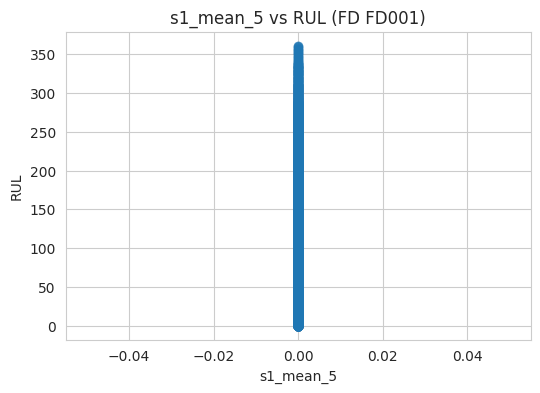

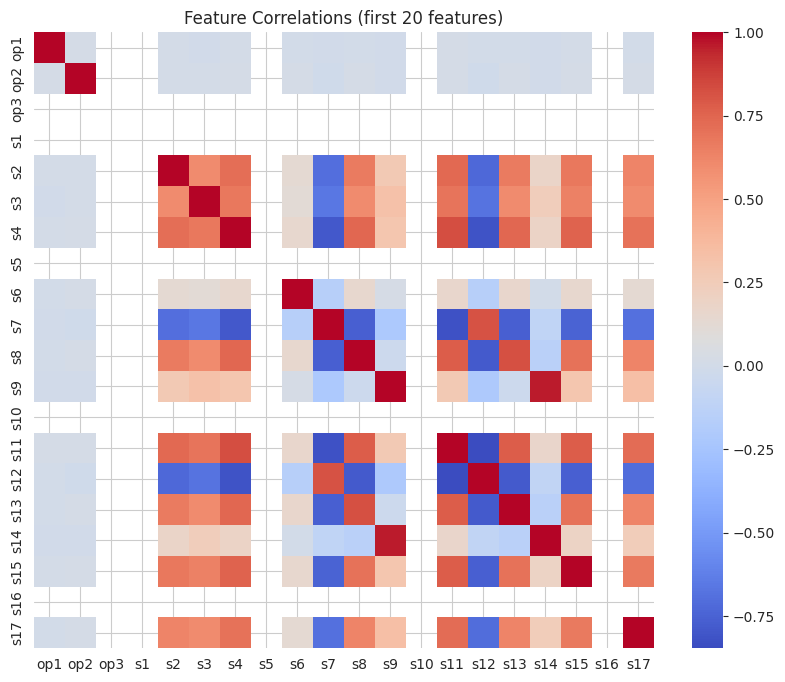

In [24]:
# Choose FD001 to view
fd = "FD001"
feat_dir = "features_nasa"
print("Files in features_nasa:", os.listdir(feat_dir))

X_train = pd.read_csv(os.path.join(feat_dir, f"X_train_feats_{fd}.csv"))
y_train = pd.read_csv(os.path.join(feat_dir, f"y_train_feats_{fd}.csv"))

print("X_train shape:", X_train.shape)
print("y_train stats:\n", y_train.describe())

# Draw a feature vs RUL scatter plot
feat = "s1_mean_5"
if feat in X_train.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(X_train[feat], y_train, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("RUL")
    plt.title(f"{feat} vs RUL (FD {fd})")
    plt.show()

#Draw a correlation heatmap (top 20 features)
subset = X_train.iloc[:, :20]
corr = subset.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlations (first 20 features)")
plt.show()
